#**Classification Dataset Cifar-10**


##**Import Library dan Dataset**

In [1]:
#import library
import matplotlib.pyplot as plt #untuk ploting
import numpy as np #untuk mengolah data
import cv2 #untuk image preprocessing
from keras.datasets import cifar10 #untuk dataset
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, MaxPool2D, Flatten, Dense, Dropout, Activation #untuk classification
from keras.models import Sequential, load_model #untuk classification
from sklearn.model_selection import train_test_split #untuk split dataset
from sklearn.metrics import confusion_matrix , classification_report #untuk evaluation
from sklearn.model_selection import KFold #untuk evaluation
import seaborn as sns #untuk plot matrix
from sklearn.cluster import KMeans #untuk preprocessing
from skimage.filters import threshold_otsu #untuk preprocessing
from PIL import Image #untuk resize image dari input manual
import os #untuk akses files colab
print("import library berhasil!!!")

import library berhasil!!!


In [2]:
#Menggabungkan data kembali, agar data dapat di split manual
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

image = np.concatenate((x_train, x_test), axis=0)
label = np.concatenate((y_train, y_test), axis=0)

print("Image:", image.shape)
print("Label:", label.shape)

Image: (60000, 32, 32, 3)
Label: (60000, 1)


In [3]:
#menentukan kategori dari label
labels = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
print("Total Kategori: {} -> {}".format(len(labels),labels))

Total Kategori: 10 -> ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [4]:
#function untuk menampilkan gambar  ----------------------------------------------------
def plot_many_image(row, col, image, label): 
  plt.figure(figsize=(15,7))
  for i in range(row * col):
    plt.subplot(row, col, i + 1)
    plt.imshow(image[i], cmap = 'gray')
    plt.xlabel(labels[label[i]], fontsize = 13)

#function untuk menampilkan gambar prediksi dan asli  ----------------------------------------------------
def plot_predict_image(row, col, image, pred_label, act_label): 
  plt.figure(figsize=(20,9))
  for i in range(row * col):
    plt.subplot(row, col, i + 1)
    plt.imshow(image[i], cmap = 'gray')
    plt.xlabel("Predict: {}\n Actual: {}".format(labels[pred_label[i]], labels[act_label[i]]), fontsize = 20)

#function untuk cek hasil preprocessing ----------------------------------------------------------
def cek_image(image, title=None): 
  row = 1
  if(len(image)>5): col = 5
  else: col = len(image)
  plt.figure(figsize=(20,10))
  for i in range(row * col):
    plt.subplot(row, col, i + 1)
    plt.imshow(image[i], cmap = 'gray')
    plt.title(title)

#cara manggil:
# plot_many_image(1, 5, image, label)
# plot_predict_image(2, 5, x_testing, y_pred_classes, y_testing)
# cek_image(image, "")

##**Preprocessing**

In [5]:
#reshape label --------------------------------------------------------------------------------------
def reshape_label(y_list_temp):
  y_list = y_list_temp.reshape(-1,)
  print("Reshape: {} -> {}".format(y_list_temp.shape, y_list.shape))
  return y_list

label = reshape_label(label)  

Reshape: (60000, 1) -> (60000,)


In [6]:
#preprocessing grayscale ----------------------------------------------------------------------------
def preprocessing_grayscale(x_list_temp):
  x_list = list(x_list_temp)
  #grayscale image
  for i in range (len(x_list)):
    #inisialisasi setiap gambar
    image_process = x_list[i]

    #grayscale
    image_process = cv2.cvtColor(image_process, cv2.COLOR_BGR2GRAY)

    #kembalikan gambar yang telah dipreprocessing
    x_list[i] = image_process

  x_list = np.array(x_list)
  print("Grayscale {} \n{} -> {}".format("-"*40, x_list_temp.shape, x_list.shape))
  print("({}) -> ({})".format(x_list_temp.dtype, x_list.dtype))
  print("({}) -> ({}) ".format(np.min(x_list),np.max(x_list)))
  cek_image(x_list, "Grayscale")
  return x_list

#preprocessing histogram equalization -----------------------------------------------------------------
def preprocessing_equalization(x_list_temp):
  if(len(x_list_temp.shape)==3):
    x_list = list(x_list_temp)
    for i in range (len(x_list)):
      #inisialisasi setiap gambar
      image_process = x_list[i]

      #equalizehist
      image_result = cv2.equalizeHist(image_process)

      #kembalikan gambar yang telah dipreprocessing
    x_list[i] = image_result
  
  elif(x_list_temp.shape[3] == 3):
    x_list = list(x_list_temp)
    for i in range (len(x_list)):
      #inisialisasi setiap gambar
      image_process = x_list[i]
      image_result = image_process
      #equalizehist
      image_result[:,:,0] = cv2.equalizeHist(image_process[:,:,0])
      image_result[:,:,1] = cv2.equalizeHist(image_process[:,:,1])
      image_result[:,:,2] = cv2.equalizeHist(image_process[:,:,2])

      #kembalikan gambar yang telah dipreprocessing
    x_list[i] = image_result
        
  x_list = np.array(x_list)
  print("Histogram Equalization {} \n({}) -> ({})".format("-"*27, x_list_temp.dtype, x_list.dtype))
  print("({}) -> ({})".format(np.min(x_list),np.max(x_list)))
  cek_image(x_list, "Histogram Equalization")
  return x_list

#laplacian filtering (sharpening) --------------------------------------------------------------------
def preprocessing_laplacian(x_list_temp):
  x_list = list(x_list_temp)
  for i in range (len(x_list)):
    #inisialisasi setiap gambar
    image_process = x_list[i]

    #laplacian
    laplacian = cv2.Laplacian(image_process, cv2.CV_64F, ksize=3)
    image_result = image_process - laplacian
    image_result = cv2.convertScaleAbs(image_result)

    #kembalikan gambar yang telah dipreprocessing
    x_list[i] = image_result

  x_list = np.array(x_list)
  print("Laplacian {} \n({}) -> ({})".format("-"*40, x_list_temp.dtype, x_list.dtype))
  print("({}) -> ({})".format(np.min(x_list),np.max(x_list)))
  cek_image(x_list, "Laplacian Filtering")
  return x_list

#sobel operators -----------------------------------------------------------------------------------
def preprocessing_sobel(x_list_temp):
  x_list = list(x_list_temp)
  for i in range (len(x_list)):
    #inisialisasi setiap gambar
    image_process = x_list[i]

    #sobel
    image_process_sobel_x = cv2.Sobel(image_process, cv2.CV_64F, 1, 0, ksize=3)
    image_process_sobel_y = cv2.Sobel(image_process, cv2.CV_64F, 0, 1, ksize=3)
    image_process_sobel = np.sqrt(image_process_sobel_x ** 2 + image_process_sobel_y ** 2)
    image_result = cv2.convertScaleAbs(image_process_sobel)

    #kembalikan gambar yang telah dipreprocessing
    x_list[i] = image_result

  x_list = np.array(x_list)
  print("Sobel {} \n({}) -> ({})".format("-"*44, x_list_temp.dtype, x_list.dtype))
  print("({}) -> ({})".format(np.min(x_list),np.max(x_list)))
  cek_image(x_list, "Sobel Operator")
  return x_list

#region based segmentation -------------------------------------------------------------------------
def preprocessing_segmentation(x_list_temp):
  x_list = list(x_list_temp)
  for i in range (len(x_list)):
    #inisialisasi setiap gambar
    image_process = x_list[i]
    
    #segmentation otsu thresholding
    thresh = threshold_otsu(image_process)
    image_process_th = np.zeros(shape=image_process.shape)
    image_process_th[image_process < thresh] = 255
    image_result = image_process + image_process_th
    image_result[image_result > 255] = 255

    #kembalikan gambar yang telah dipreprocessing
    x_list[i] = image_result

  x_list = np.array(x_list)
  print("Segmentation {} \n({}) -> ({})".format("-"*37, x_list_temp.dtype, x_list.dtype))
  print("({}) -> ({})".format(np.min(x_list),np.max(x_list)))
  cek_image(x_list, "Region Based Segmentation")
  return x_list

#normalisasi image ----------------------------------------------------------------------------------
def normalisasi_image(x_list_temp):
  x_list = x_list_temp / 255
  print("Normalisasi {} \n({}) -> ({})".format("-"*38, x_list_temp.dtype, x_list.dtype))
  print("({}) -> ({}) \n".format(np.min(x_list),np.max(x_list)))
  cek_image(x_list, "Normalisasi")
  return x_list

Normalisasi -------------------------------------- 
(uint8) -> (float64)
(0.0) -> (1.0) 

Preprocessing Berhasil!!!



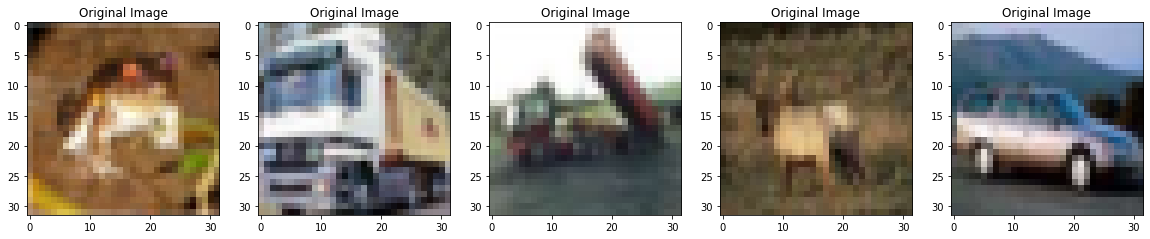

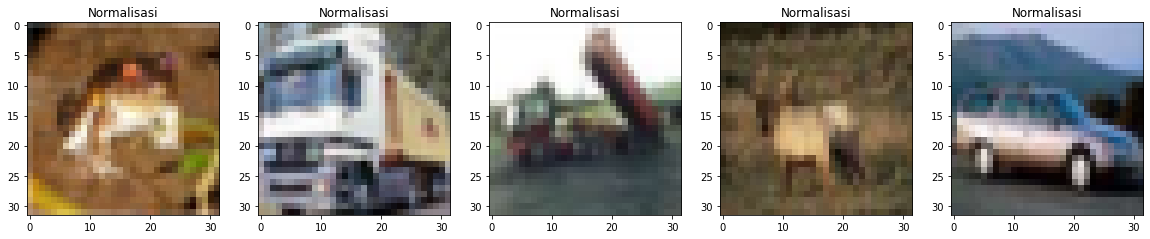

In [7]:
cek_image(image, "Original Image")
#image = preprocessing_equalization(image)
#image = preprocessing_grayscale(image)
#image = preprocessing_laplacian(image)
#image = preprocessing_sobel(image)
#image = preprocessing_segmentation(image)

image = normalisasi_image(image) #wajib
print("Preprocessing Berhasil!!!\n")

##**Classification**


###**Spliting**

In [8]:
#split manual
persentase_test = 20
persentase_train = 100 - persentase_test
x_train, x_test, y_train, y_test = train_test_split(image, label, test_size=(persentase_test/100), random_state=1, shuffle=True)
print("Training {}% = | Image: {} | | Label: {} |".format(persentase_train, x_train.shape, y_train.shape))
print("Testing  {}% = | Image: {} | | Label: {} |".format(persentase_test, x_test.shape, y_test.shape))

Training 80% = | Image: (48000, 32, 32, 3) | | Label: (48000,) |
Testing  20% = | Image: (12000, 32, 32, 3) | | Label: (12000,) |


###**Training**

In [9]:
#function untuk membuat model cnn -------------------------------------------------------------------
def model_cnn():
  if(len(x_train.shape) == 3): 
    image_shape = (x_train.shape[1], x_train.shape[2], 1)

  elif(x_train.shape[3] == 3): 
    image_shape = x_train.shape[1:]

  model = Sequential()

  model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=image_shape))
  model.add(Activation("relu"))
  model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(1024))
  model.add(Activation("relu"))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation="softmax"))
  
  return model

In [10]:
#buat model cnn
cnn = model_cnn()
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                        

In [11]:
#training (± 175 detik)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn.fit(x_train, y_train, epochs=35, batch_size=400, validation_data=(x_test, y_test), verbose=1)

Epoch 1/35
120/120 [==============================] - 12s 45ms/step - loss: 1.8693 - accuracy: 0.3037 - val_loss: 1.6035 - val_accuracy: 0.4113
Epoch 2/35
120/120 [==============================] - 5s 42ms/step - loss: 1.4642 - accuracy: 0.4597 - val_loss: 1.2715 - val_accuracy: 0.5337
Epoch 3/35
120/120 [==============================] - 5s 40ms/step - loss: 1.2626 - accuracy: 0.5411 - val_loss: 1.1057 - val_accuracy: 0.6058
Epoch 4/35
120/120 [==============================] - 5s 43ms/step - loss: 1.1093 - accuracy: 0.6019 - val_loss: 0.9866 - val_accuracy: 0.6513
Epoch 5/35
120/120 [==============================] - 5s 41ms/step - loss: 0.9819 - accuracy: 0.6508 - val_loss: 0.8794 - val_accuracy: 0.6942
Epoch 6/35
120/120 [==============================] - 5s 43ms/step - loss: 0.9104 - accuracy: 0.6765 - val_loss: 0.8274 - val_accuracy: 0.7082
Epoch 7/35
120/120 [==============================] - 5s 43ms/step - loss: 0.8179 - accuracy: 0.7122 - val_loss: 0.7540 - val_accuracy: 0.734

###**Testing**

375/375 [==============================] - 1s 2ms/step
----------------------------------------
Predictions label (10):
[1 6 6 5 1 9 5 3 9 6]
Actual label      (10):
[1 6 6 3 1 1 5 3 9 6]
----------------------------------------
Correct Prediction : 9918
Incorrect Prediction : 2082
----------------------------------------


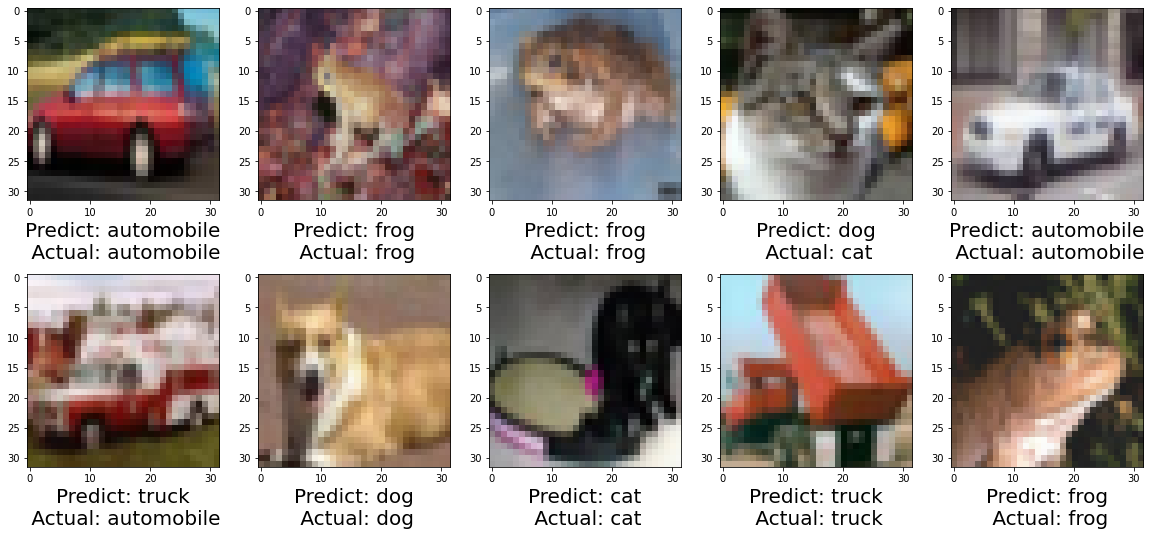

In [12]:
#testing
x_testing = x_test
y_testing = y_test
y_pred = cnn.predict(x_testing, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=-1)

length = len(y_pred)
count = 0
for i in range(length):
  if(y_pred_classes[i] == y_testing[i]):
    count+=1

print("-"*40)
print("Predictions label (10):\n" + str(y_pred_classes[:10]))
print("Actual label      (10):\n" + str(y_testing[:10]))
print("-"*40)
print("Correct Prediction : " + str(count))
print("Incorrect Prediction : " + str(length-count))
print("-"*40)

plot_predict_image(2, 5, x_testing, y_pred_classes, y_testing)

##**Evaluation**

In [13]:
#Evaluate
score = cnn.evaluate(x_testing, y_testing, verbose=0)
print('loss: ' + str(score[0]))
print('accuracy: ' + str(score[1]*100) + "%")

loss: 0.5765116214752197
accuracy: 82.64999985694885%


Confusion Matrix:

 [[1012   13   30   23    9    3    4    9   60   43]
 [   9 1071    0    4    0    5    7    1   19   57]
 [  55    5  860   66   52   71   51   28    8   10]
 [  13    4   41  803   32  199   45   20   15   11]
 [  18    1   39   78  928   56   35   63    8    4]
 [   3    3   19  154   25  934   15   30    7    7]
 [   7    9   25   36   19   34 1046    2    4    9]
 [   5    2   13   44   23   54    6 1109    7   10]
 [  28   18    8    7    0    2    4    1 1102   22]
 [   9   56    1    6    2    3    2    4   13 1053]] 

accuracy: 82.65%



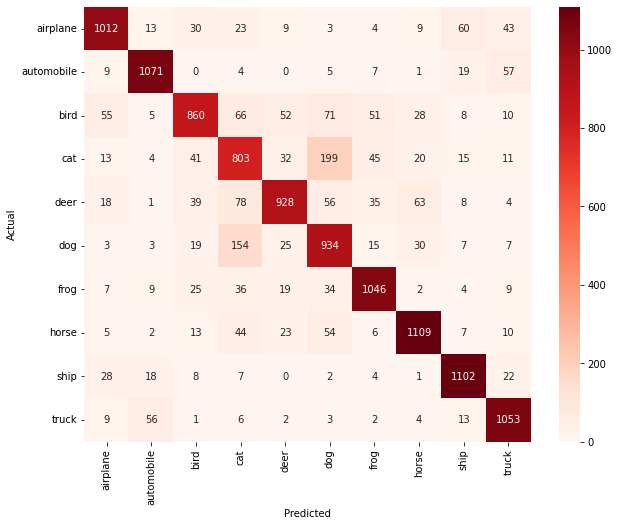

In [14]:
#Confusion Matrix
cm = confusion_matrix(y_testing, y_pred_classes)
tptn = 0
for i in range(len(cm)):
  tptn += cm[i][i]
fpfn = len(y_testing)-tptn

print("Confusion Matrix:\n\n",cm,"\n")
print('accuracy: ' + str(tptn/(tptn+fpfn)*100) + "%\n")

plt.figure(figsize=(10,8))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [15]:
#Classification Report
print("Classification Report: \n", classification_report(y_testing.reshape(-1,), y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.84      0.86      1206
           1       0.91      0.91      0.91      1173
           2       0.83      0.71      0.77      1206
           3       0.66      0.68      0.67      1183
           4       0.85      0.75      0.80      1230
           5       0.69      0.78      0.73      1197
           6       0.86      0.88      0.87      1191
           7       0.88      0.87      0.87      1273
           8       0.89      0.92      0.91      1192
           9       0.86      0.92      0.89      1149

    accuracy                           0.83     12000
   macro avg       0.83      0.83      0.83     12000
weighted avg       0.83      0.83      0.83     12000



In [16]:
#Kfold
num_folds = 3

acc_per_fold = []
loss_per_fold = []

image = np.concatenate((x_train, x_testing), axis=0)
label = np.concatenate((y_train, y_testing), axis=0)

kfold = KFold(n_splits=num_folds, shuffle=True)
print(kfold,'\n')

fold_no = 1
for train, test in kfold.split(image, label):
  print('-'*60)
  print(f'Training for fold {fold_no} ...')

  cnn = model_cnn()
  
  cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  history = cnn.fit(image[train], label[train], batch_size=400, epochs=35, verbose=1)

  scores = cnn.evaluate(image[test], label[test], verbose=0)
  print(f'Score for fold {fold_no}: {cnn.metrics_names[0]} of {scores[0]}; {cnn.metrics_names[1]} of {scores[1]*100}%\n')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_no = fold_no + 1


print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('-'*60)
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('-'*60)
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('-'*60)

KFold(n_splits=3, random_state=None, shuffle=True) 

------------------------------------------------------------
Training for fold 1 ...
Epoch 1/35
100/100 [==============================] - 4s 37ms/step - loss: 1.9233 - accuracy: 0.2819
Epoch 2/35
100/100 [==============================] - 4s 37ms/step - loss: 1.4950 - accuracy: 0.4506
Epoch 3/35
100/100 [==============================] - 4s 37ms/step - loss: 1.3066 - accuracy: 0.5293
Epoch 4/35
100/100 [==============================] - 4s 39ms/step - loss: 1.1422 - accuracy: 0.5924
Epoch 5/35
100/100 [==============================] - 4s 37ms/step - loss: 1.0350 - accuracy: 0.6341
Epoch 6/35
100/100 [==============================] - 4s 37ms/step - loss: 0.9483 - accuracy: 0.6670
Epoch 7/35
100/100 [==============================] - 4s 38ms/step - loss: 0.8738 - accuracy: 0.6908
Epoch 8/35
100/100 [==============================] - 4s 38ms/step - loss: 0.8196 - accuracy: 0.7139
Epoch 9/35
100/100 [==============================] - 

In [22]:
#testing
x_testing = x_test#[:10]
y_testing = y_test#[:10]
y_pred = cnn.predict(x_testing, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=-1)

length = len(y_pred)
count = 0
for i in range(length):
  if(y_pred_classes[i] == y_testing[i]):
    count+=1

print("-"*40)
print("Predictions label (10):\n" + str(y_pred_classes[:10]))
print("Actual label      (10):\n" + str(y_testing[:10]))
print("-"*40)
print("Correct Prediction : " + str(count))
print("Incorrect Prediction : " + str(length-count))
print("-"*40)

#Evaluate
score = cnn.evaluate(x_testing, y_testing, verbose=0)
print('loss: ' + str(score[0]))
print('accuracy: ' + str(score[1]*100) + "%")

375/375 [==============================] - 1s 4ms/step
----------------------------------------
Predictions label (10):
[1 6 6 3 1 9 5 9 9 3]
Actual label      (10):
[1 6 6 3 1 1 5 3 9 6]
----------------------------------------
Correct Prediction : 11157
Incorrect Prediction : 843
----------------------------------------
loss: 0.2527792453765869
accuracy: 92.97500252723694%


##**Uji dengan Input Gambar**

In [25]:
#Baca Gambar
#['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
directories = os.listdir('Input')
input_label = np.array([3,1,1,2,5])
print(directories)

['cat.jpg', 'car.jpg', 'car2.jpg', 'bird.jpg', 'dog.jpg']


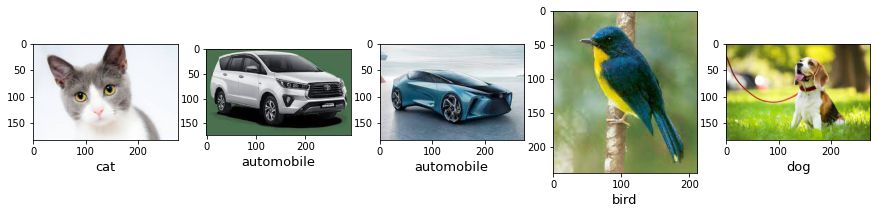

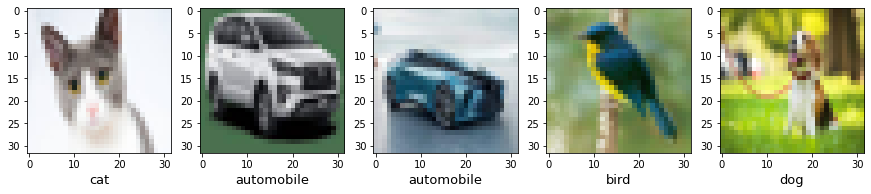

In [26]:
#Resize
input_image = []
temp_image = []
for i in range(len(directories)):
  image_pil = Image.open('Input/'+directories[i])
  temp_image.append(image_pil)
  image_pil = image_pil.resize((32,32))
  image = np.array(image_pil)
  input_image.append(image)

plot_many_image(1,5,temp_image, input_label)
plot_many_image(1,5,input_image, input_label)

Normalisasi -------------------------------------- 
(uint8) -> (float64)
(0.0) -> (1.0) 


Preprocessing Berhasil!!!


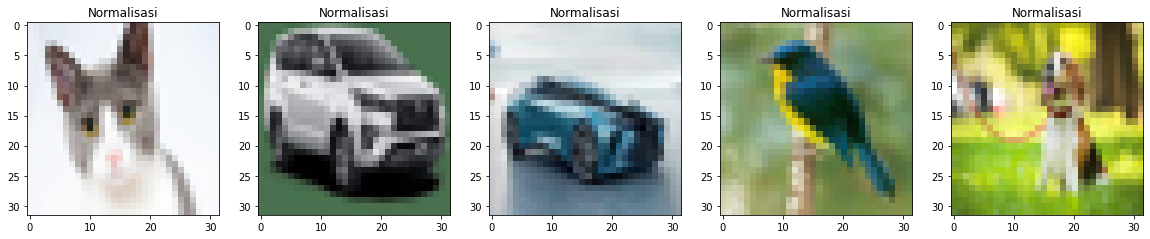

In [27]:
#Preprocessing
input_image = np.array(input_image)
input_image = normalisasi_image(input_image)
print("\nPreprocessing Berhasil!!!")

1/1 [==============================] - 0s 234ms/step
----------------------------------------
Predictions label:
[3 1 1 2 7]
Actual label     :
[3 1 1 2 5]
----------------------------------------
Correct Prediction : 4
Incorrect Prediction : 1
----------------------------------------


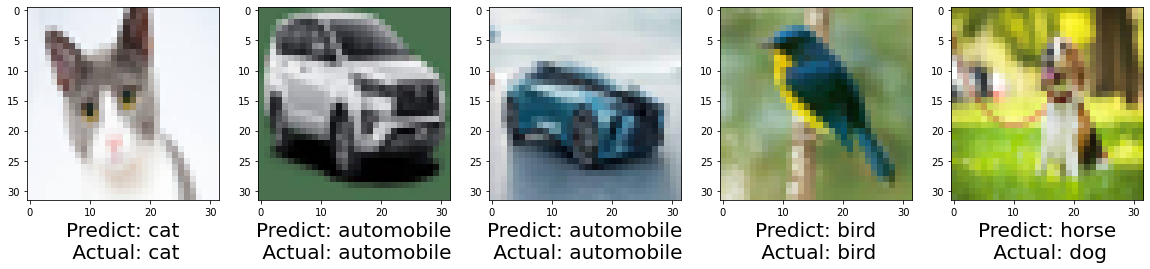

In [28]:
#testing 
y_pred = cnn.predict(input_image, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=-1)
length = len(y_pred)
count = 0
for i in range(length):
  if(y_pred_classes[i] == input_label[i]):
    count+=1

print("-"*40)
print("Predictions label:\n" + str(y_pred_classes))
print("Actual label     :\n" + str(input_label))
print("-"*40)
print("Correct Prediction : " + str(count))
print("Incorrect Prediction : " + str(length-count))
print("-"*40)

plot_predict_image(1, 5, input_image, y_pred_classes, input_label)